In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import network
import environment
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def memory_queue(memory,weight):
    weight = np.expand_dims(weight.T,axis=1)
    memory = np.concatenate((weight,memory),axis=2)[:,:,:-1]
    return memory

def MM_scaler(s):
    x= np.zeros(s.shape)
    for i in range(len(s)):
        x[i]=(s[i]-np.min(s[i],axis=0))/((np.max(s[i],axis=0)-np.min(s[i],axis=0))+1e-5)
    return x

def calculate_SV(value_list):
    value_array = np.array(value_list)/money
    return_array = np.log(value_array[1:]/value_array[:-1])
    SV=np.sqrt(np.var(return_array))
    SV = SV*np.sqrt(period)
    return SV

def sharpe_ratio(value_list,kospi):
    value_array = np.array(value_list)
    sigma = calculate_SV(value_list)
    APV = value_array[-1]
    excess_return = APV-kospi[-1]/kospi[0]
    sharpe_ratio = excess_return/sigma
    return sharpe_ratio
    
def beta(value,kospi):
    return_array = np.log(value[1:]/value[:-1])
    return_kospi = np.log(kospi[1:]/kospi[:-1])
    cov = np.cov(return_array,return_kospi)
    beta = cov[0,1]/cov[1,1]
    return beta

def MDD(apv):
    apv_max=[]
    apv_min=[]
    for i in range(1,period):
        apv_max.append(np.max(apv[:i]))
        apv_min.append(np.min(apv[np.argmax(apv[:i]):i]))
    drawdown = (np.array(apv_max) - np.array(apv_min))/np.array(apv_max)
    return drawdown

In [3]:
#preprocessed data loading
is_train = 0

#hyperparameters
input_day_size = 50
filter_size = 3
num_of_feature = 4
num_of_asset = 10
num_episodes = 10000 if is_train ==1 else 1
test_episodes = 2000
money = 1e+8
period = 1019 if is_train else 275

#saving
save_frequency = 100
save_path = './weights/'
save_model = 1
load_model = 1
selecting_random = False

env = environment.env(train = 0, number_of_asset = num_of_asset)

In [4]:
config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True

In [5]:
a_loss_sum = 0
s_loss_sum = 0
value_deque = deque()
AAM_deque = deque()

In [6]:
sess = tf.Session(config = config)

with tf.variable_scope('AAM'):
    allocator=network.policy(sess,num_of_asset = num_of_asset)
with tf.variable_scope('ESM'):    
    selector = network.select_network(sess)

sess.run(tf.global_variables_initializer())

saver_AAM = tf.train.Saver(var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'AAM'),max_to_keep=100)
ckpt_AAM = tf.train.get_checkpoint_state(save_path+'AAM/m_'+str(num_of_asset))
saver_ESM = tf.train.Saver(var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'ESM'),max_to_keep=100)
ckpt_ESM = tf.train.get_checkpoint_state(save_path+'ESM')

if load_model:
    saver_AAM.restore(sess,ckpt_AAM.model_checkpoint_path)
    saver_ESM.restore(sess,ckpt_ESM.model_checkpoint_path)

Device mapping:


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from ./weights/AAM/m_10\AAM-4999.cptk
INFO:tensorflow:Restoring parameters from ./weights/ESM\ESM-4999.cptk


In [7]:
score = 0
for i in range(num_episodes):
    allocator_memory = deque()
    selector_memory = deque()
    s=env.start()
    s=MM_scaler(s)
    done=False
    v=money
    weight_memory = []
    value_list = []
    bench_list = []
    while not done:
        evaluated_value = selector.predict(s)
        selected_s = env.selecting(evaluated_value,rand=selecting_random)
        selected_s = MM_scaler(selected_s)
        w = allocator.predict(selected_s)
        s_prime,r,done,v_prime,growth = env.action(w)
        s_prime=MM_scaler(s_prime)
        weight_memory.append(w)
        s = s_prime
        v = v_prime
        value_list.append(v)
        bench_list.append(env.benchmark)
        if done:
            value_deque.append(['AAM+ESM',value_list])
            value_deque.append(['ESM only',bench_list])
            score+=v/money
            print(i,'agent:',round(v/money,4), 'benchmark:',round(env.benchmark/money,4))

0 agent: 2.7818 benchmark: 1.7901


In [8]:
for i in range(test_episodes):
    value_list = []
    allocator_memory = deque()
    s=env.start()
    s = MM_scaler(s)
    done = False
    v = money
    while not done:
        selected_s = env.selecting(evaluated_value, rand = True)
        selected_s = MM_scaler(selected_s)
        w = allocator.predict(selected_s)
        s_prime,r,done,v_prime,growth = env.action(w)
        s_prime = MM_scaler(s_prime)
        s = s_prime
        v = v_prime
        value_list.append(v)
        if done:
            AAM_deque.append(value_list)
            score+=v/money
            print(i,'agent:',round(v/money,4), 'benchmark:',round(env.benchmark/money,4))

0 agent: 1.0561 benchmark: 1.4885
1 agent: 1.2611 benchmark: 1.0336
2 agent: 1.2198 benchmark: 1.0837
3 agent: 1.0206 benchmark: 1.4917
4 agent: 1.2339 benchmark: 1.3589
5 agent: 1.0929 benchmark: 1.2783
6 agent: 0.7137 benchmark: 1.1189
7 agent: 1.3921 benchmark: 1.3531
8 agent: 0.8868 benchmark: 1.2603
9 agent: 0.654 benchmark: 0.8763
10 agent: 1.739 benchmark: 1.3075
11 agent: 0.5367 benchmark: 0.9488
12 agent: 0.9597 benchmark: 0.9537
13 agent: 0.7099 benchmark: 1.1504
14 agent: 1.7384 benchmark: 1.3859
15 agent: 0.5475 benchmark: 1.0946
16 agent: 1.0751 benchmark: 1.1087
17 agent: 1.1704 benchmark: 1.3713
18 agent: 1.0011 benchmark: 1.0726
19 agent: 1.1854 benchmark: 1.3357
20 agent: 0.8986 benchmark: 1.1018
21 agent: 0.9522 benchmark: 1.4184
22 agent: 1.1093 benchmark: 1.4063
23 agent: 0.7341 benchmark: 1.3799
24 agent: 1.2911 benchmark: 1.1657
25 agent: 3.6646 benchmark: 1.5195
26 agent: 0.8173 benchmark: 1.1276
27 agent: 1.1485 benchmark: 0.9614
28 agent: 1.5282 benchmark: 1.42

233 agent: 0.9463 benchmark: 1.427
234 agent: 0.98 benchmark: 1.2824
235 agent: 1.6719 benchmark: 2.4735
236 agent: 1.5335 benchmark: 1.6181
237 agent: 0.9851 benchmark: 2.2789
238 agent: 1.0965 benchmark: 1.1172
239 agent: 0.8311 benchmark: 2.0527
240 agent: 0.7345 benchmark: 1.0244
241 agent: 1.0685 benchmark: 1.4359
242 agent: 1.3403 benchmark: 1.4045
243 agent: 1.0025 benchmark: 1.251
244 agent: 1.1841 benchmark: 1.0382
245 agent: 1.1858 benchmark: 1.1055
246 agent: 1.0294 benchmark: 1.1859
247 agent: 0.8379 benchmark: 1.047
248 agent: 1.0342 benchmark: 1.2928
249 agent: 1.791 benchmark: 1.397
250 agent: 1.1597 benchmark: 1.0262
251 agent: 0.6357 benchmark: 1.2323
252 agent: 0.727 benchmark: 1.3717
253 agent: 1.2735 benchmark: 2.5257
254 agent: 1.55 benchmark: 1.329
255 agent: 1.3351 benchmark: 1.0054
256 agent: 0.6234 benchmark: 1.1132
257 agent: 0.6501 benchmark: 1.2349
258 agent: 0.5991 benchmark: 1.1153
259 agent: 0.7635 benchmark: 1.034
260 agent: 2.6 benchmark: 1.4595
261 age

463 agent: 2.212 benchmark: 1.5134
464 agent: 2.1312 benchmark: 1.2493
465 agent: 1.4131 benchmark: 1.3843
466 agent: 0.6294 benchmark: 0.9514
467 agent: 0.8772 benchmark: 1.1616
468 agent: 1.2117 benchmark: 1.0313
469 agent: 1.4862 benchmark: 2.2254
470 agent: 1.2365 benchmark: 1.1738
471 agent: 0.9436 benchmark: 1.1492
472 agent: 1.309 benchmark: 1.1483
473 agent: 0.7284 benchmark: 1.1874
474 agent: 1.1 benchmark: 0.9647
475 agent: 0.9643 benchmark: 1.0558
476 agent: 1.5261 benchmark: 1.5006
477 agent: 0.7546 benchmark: 0.9638
478 agent: 1.4978 benchmark: 1.2272
479 agent: 0.8705 benchmark: 1.0724
480 agent: 0.6435 benchmark: 1.3428
481 agent: 1.1108 benchmark: 0.8839
482 agent: 1.167 benchmark: 1.6002
483 agent: 0.7526 benchmark: 1.1625
484 agent: 0.8917 benchmark: 1.3017
485 agent: 0.8816 benchmark: 1.3042
486 agent: 1.1269 benchmark: 1.1595
487 agent: 0.9119 benchmark: 1.0566
488 agent: 0.6452 benchmark: 1.1346
489 agent: 1.344 benchmark: 1.0845
490 agent: 1.5931 benchmark: 1.206


692 agent: 1.4278 benchmark: 1.1224
693 agent: 1.1509 benchmark: 1.4055
694 agent: 0.7689 benchmark: 1.3251
695 agent: 1.1572 benchmark: 1.4568
696 agent: 0.9317 benchmark: 1.1639
697 agent: 0.9763 benchmark: 1.0926
698 agent: 0.9651 benchmark: 1.0668
699 agent: 0.6863 benchmark: 0.9648
700 agent: 0.7052 benchmark: 1.0898
701 agent: 1.1732 benchmark: 1.0523
702 agent: 0.7139 benchmark: 1.254
703 agent: 1.1307 benchmark: 1.1644
704 agent: 1.0193 benchmark: 1.0962
705 agent: 0.9459 benchmark: 1.3139
706 agent: 0.8454 benchmark: 0.9104
707 agent: 1.5151 benchmark: 1.1229
708 agent: 1.6542 benchmark: 1.1729
709 agent: 1.5218 benchmark: 1.3145
710 agent: 1.4963 benchmark: 1.1548
711 agent: 0.6443 benchmark: 1.0729
712 agent: 0.7683 benchmark: 0.8387
713 agent: 1.7999 benchmark: 1.3737
714 agent: 1.9723 benchmark: 1.6603
715 agent: 1.0418 benchmark: 1.955
716 agent: 1.2443 benchmark: 2.1858
717 agent: 0.8119 benchmark: 1.1916
718 agent: 1.327 benchmark: 1.236
719 agent: 0.9057 benchmark: 0.9

922 agent: 0.8388 benchmark: 1.1733
923 agent: 1.2436 benchmark: 1.0505
924 agent: 1.3899 benchmark: 1.3134
925 agent: 0.8239 benchmark: 1.0585
926 agent: 0.719 benchmark: 1.0519
927 agent: 1.4612 benchmark: 1.6316
928 agent: 1.9015 benchmark: 1.0952
929 agent: 1.414 benchmark: 1.2418
930 agent: 1.1871 benchmark: 1.4062
931 agent: 0.7652 benchmark: 0.942
932 agent: 1.6373 benchmark: 1.3181
933 agent: 0.8105 benchmark: 1.0862
934 agent: 1.3396 benchmark: 1.3605
935 agent: 1.0996 benchmark: 1.2115
936 agent: 1.0316 benchmark: 1.0883
937 agent: 1.1416 benchmark: 1.4525
938 agent: 1.1323 benchmark: 1.2105
939 agent: 0.6761 benchmark: 1.0336
940 agent: 0.5181 benchmark: 1.3616
941 agent: 0.9708 benchmark: 0.8064
942 agent: 1.945 benchmark: 1.1493
943 agent: 1.3115 benchmark: 1.3967
944 agent: 0.504 benchmark: 0.8642
945 agent: 0.9118 benchmark: 1.4814
946 agent: 2.8308 benchmark: 1.562
947 agent: 0.7634 benchmark: 1.0549
948 agent: 0.7551 benchmark: 1.1623
949 agent: 0.9547 benchmark: 1.295

1148 agent: 1.8336 benchmark: 1.29
1149 agent: 1.3004 benchmark: 1.1337
1150 agent: 1.1779 benchmark: 1.0668
1151 agent: 1.0592 benchmark: 0.98
1152 agent: 0.798 benchmark: 1.1147
1153 agent: 0.6989 benchmark: 1.0281
1154 agent: 0.7241 benchmark: 0.9908
1155 agent: 1.7017 benchmark: 1.6715
1156 agent: 1.5815 benchmark: 1.2949
1157 agent: 1.3159 benchmark: 1.3415
1158 agent: 0.9745 benchmark: 1.1633
1159 agent: 0.8701 benchmark: 1.3067
1160 agent: 1.0393 benchmark: 1.0916
1161 agent: 1.1063 benchmark: 1.4222
1162 agent: 0.8915 benchmark: 1.1495
1163 agent: 1.7918 benchmark: 1.5146
1164 agent: 1.3201 benchmark: 1.2461
1165 agent: 2.3179 benchmark: 1.2382
1166 agent: 0.6271 benchmark: 1.1858
1167 agent: 1.7553 benchmark: 1.3548
1168 agent: 1.3608 benchmark: 1.1898
1169 agent: 0.4255 benchmark: 1.1265
1170 agent: 2.0834 benchmark: 1.309
1171 agent: 1.3673 benchmark: 1.4743
1172 agent: 1.8221 benchmark: 1.2342
1173 agent: 1.3395 benchmark: 1.1506
1174 agent: 1.2509 benchmark: 1.0609
1175 ag

1371 agent: 0.4254 benchmark: 0.9608
1372 agent: 1.7022 benchmark: 1.0839
1373 agent: 0.9475 benchmark: 1.2509
1374 agent: 0.9896 benchmark: 1.1722
1375 agent: 0.7935 benchmark: 1.0654
1376 agent: 1.2138 benchmark: 2.006
1377 agent: 1.157 benchmark: 1.195
1378 agent: 1.4611 benchmark: 1.0696
1379 agent: 0.3849 benchmark: 1.0627
1380 agent: 0.5195 benchmark: 0.9967
1381 agent: 1.0835 benchmark: 1.1339
1382 agent: 1.4127 benchmark: 1.3031
1383 agent: 0.6271 benchmark: 0.8443
1384 agent: 1.2239 benchmark: 1.1443
1385 agent: 0.7358 benchmark: 1.071
1386 agent: 1.2107 benchmark: 1.21
1387 agent: 1.7007 benchmark: 1.5143
1388 agent: 1.0175 benchmark: 1.2515
1389 agent: 1.9501 benchmark: 0.9905
1390 agent: 1.9741 benchmark: 1.6039
1391 agent: 1.6777 benchmark: 1.178
1392 agent: 0.7652 benchmark: 1.1459
1393 agent: 1.1485 benchmark: 1.2496
1394 agent: 1.1485 benchmark: 1.0545
1395 agent: 1.2949 benchmark: 1.4087
1396 agent: 2.225 benchmark: 1.5553
1397 agent: 0.7982 benchmark: 1.1321
1398 agen

1594 agent: 0.9646 benchmark: 1.3709
1595 agent: 1.3872 benchmark: 1.3468
1596 agent: 0.9488 benchmark: 1.5676
1597 agent: 0.9815 benchmark: 1.2522
1598 agent: 1.8511 benchmark: 1.4161
1599 agent: 1.2224 benchmark: 2.3459
1600 agent: 1.4757 benchmark: 2.5301
1601 agent: 1.9075 benchmark: 2.467
1602 agent: 0.7613 benchmark: 1.1319
1603 agent: 1.3866 benchmark: 2.3303
1604 agent: 1.5151 benchmark: 1.1837
1605 agent: 2.4746 benchmark: 1.22
1606 agent: 0.3549 benchmark: 1.0613
1607 agent: 0.8033 benchmark: 0.9024
1608 agent: 0.9514 benchmark: 1.5523
1609 agent: 0.9898 benchmark: 2.1463
1610 agent: 0.9214 benchmark: 1.0358
1611 agent: 1.2121 benchmark: 0.9926
1612 agent: 1.8345 benchmark: 0.9395
1613 agent: 1.9894 benchmark: 1.346
1614 agent: 0.7234 benchmark: 1.0425
1615 agent: 1.1054 benchmark: 1.3678
1616 agent: 1.3764 benchmark: 1.0379
1617 agent: 1.0436 benchmark: 1.0895
1618 agent: 0.7005 benchmark: 1.0125
1619 agent: 1.0331 benchmark: 1.1271
1620 agent: 1.145 benchmark: 1.093
1621 ag

1817 agent: 0.9866 benchmark: 1.1619
1818 agent: 0.7344 benchmark: 1.4135
1819 agent: 1.8888 benchmark: 1.2346
1820 agent: 1.1353 benchmark: 1.2414
1821 agent: 0.5115 benchmark: 1.0854
1822 agent: 0.7735 benchmark: 1.001
1823 agent: 1.6103 benchmark: 1.3871
1824 agent: 1.3784 benchmark: 1.001
1825 agent: 0.794 benchmark: 0.9717
1826 agent: 0.4855 benchmark: 1.0229
1827 agent: 1.1594 benchmark: 1.1118
1828 agent: 1.3408 benchmark: 1.1396
1829 agent: 1.3961 benchmark: 1.0987
1830 agent: 1.2148 benchmark: 1.4813
1831 agent: 0.9088 benchmark: 1.2847
1832 agent: 1.4271 benchmark: 1.3297
1833 agent: 0.7176 benchmark: 0.9303
1834 agent: 1.9607 benchmark: 1.0152
1835 agent: 0.5235 benchmark: 1.1145
1836 agent: 1.3085 benchmark: 1.0663
1837 agent: 0.9583 benchmark: 0.9722
1838 agent: 0.9003 benchmark: 0.9963
1839 agent: 0.7734 benchmark: 2.4714
1840 agent: 0.9952 benchmark: 0.8129
1841 agent: 0.9957 benchmark: 1.2948
1842 agent: 1.0657 benchmark: 2.2388
1843 agent: 1.4185 benchmark: 1.0054
1844

In [9]:
import benchmark
import pandas as pd

value_array = np.array(value_deque[0][1])
ESM_value_array = np.array(value_deque[1][1])
AAM_mean_deque = deque()
AAM_array = np.array(AAM_deque)
for i in range(env.time):
    AAM_mean_deque.append(np.mean(AAM_array[:,i]))
AAM_mean_array = np.array(AAM_mean_deque)
AAM_mean_array

k200price = pd.read_csv("./data/KOSPI200index.csv")
k200 = k200price[['종가']].to_numpy(dtype=np.float32)
k200 = k200[1:-1]
k200 = k200[::-1]

benchmark = benchmark.benchmark(num_of_asset = num_of_asset)
ucrp,ubah = benchmark.execute(iteration=test_episodes)
UCRP = np.mean(ucrp,axis = 0)
UBAH = np.mean(ubah,axis = 0)

best = env.env_data.loaded_list[86][50:-1,0]
best = best/env.env_data.loaded_list[86][49,0]

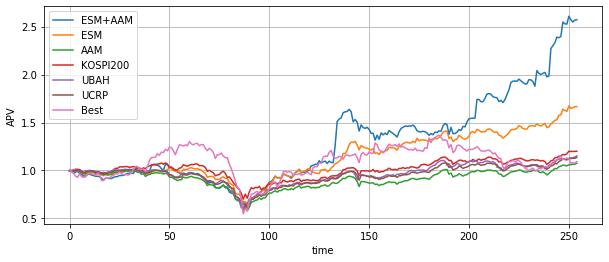

In [10]:
plt.figure(figsize = (10,4))
plt.grid(1)
plt.plot(value_array[:-19]/money,label='ESM+AAM')
plt.plot(ESM_value_array[:-19]/money,label = 'ESM')
plt.plot(AAM_mean_array[:-19]/money,label = 'AAM')
plt.plot(k200[:-19]/k200[0],label='KOSPI200')
plt.plot(UBAH[:-19]/money,label = 'UBAH')
plt.plot(UCRP[:-19]/money,label = 'UCRP')
plt.plot(best[:-19],label = 'Best')
plt.xlabel("time")
plt.ylabel("APV")
plt.legend()
plt.show()

In [11]:
value_array= value_array[:-19]
ESM_value_array = ESM_value_array[:-19]
AAM_mean_array = AAM_mean_array[:-19]
k200 = k200[:-19]
UBAH = UBAH[:-19]
UCRP = UCRP[:-19]
best = best[:-19]

base_rate = np.array(np.loadtxt('./data/base_rate_test.csv',delimiter=',',dtype = str)[1:][:,1],dtype =np.float32)

In [12]:
print('esm+aam:',np.max(MDD(value_array/money)))
print('aam:',np.max(MDD(ESM_value_array/money)))

mdd_ucrp_list = []    
for i in ucrp:
    mdd_ucrp_list.append(np.max(MDD(i[:-19]/money)))
print('ucrp:',np.mean(np.array(mdd_ucrp_list)))

mdd_ubah_list = []
for i in ubah:
    mdd_ubah_list.append(np.max(MDD(i[:-19]/money)))
    
print('ubah:',np.mean(np.array(mdd_ubah_list)))

mdd_aam_list=[]
for i in AAM_array:
    mdd_aam_list.append(np.max(MDD(i[:-19]/money)))
    
print('aam:',np.mean(np.array(mdd_aam_list)))

esm+aam: 0.40191826
aam: 0.37856498
ucrp: 0.42001268
ubah: 0.41275042
aam: 0.47236156


In [13]:
print('ksp:',k200[-1]/k200[0])
print('best:',best[-1])
print('esm+aam:',value_array[-1]/money)
print('esm:',ESM_value_array[-1]/money)
print('ucrp:',UCRP[-1]/money)
print('ubah:',UBAH[-1]/money)
print('aam:',AAM_mean_array[-1]/money)

ksp: [1.2008461]
best: 1.0922331
esm+aam: 2.57061712
esm: 1.66547248
ucrp: 1.1369772
ubah: 1.15193384
aam: 1.07609312


In [14]:
print('ESM+aam:',calculate_SV(value_array))
print('ESM:',calculate_SV(ESM_value_array))
print('best:',calculate_SV(best))
print('ksp:',calculate_SV(k200/k200[0]))

sv_ucrp_list = []    
for i in ucrp:
    sv_ucrp_list.append(calculate_SV(i[:-19]/money))
print('ucrp:',np.mean(np.array(sv_ucrp_list)))

sv_ubah_list = []
for i in ubah:
    sv_ubah_list.append(calculate_SV(i[:-19]/money))
    
print('ubah:',np.mean(np.array(sv_ubah_list)))

sv_aam_list=[]
for i in AAM_array:
    sv_aam_list.append(calculate_SV(i[:-19]/money))
    
print('aam:',np.mean(np.array(sv_aam_list)))

ESM+aam: 0.48976074673162945
ESM: 0.32543600364209385
best: 0.5775155848550355
ksp: 0.2940536833097194
ucrp: 0.3530840409004526
ubah: 0.36282925181820636
aam: 0.47889034174535045


In [15]:
Rf = [1.0,1.008]
print(sharpe_ratio(value_array/money,Rf))
print(sharpe_ratio(ESM_value_array/money,Rf))

sr_ubah_list = []    
for i in ubah:
    sr_ubah_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('ubah:',np.mean(np.array(sr_ubah_list)))

sr_ucrp_list = []    
for i in ucrp:
    sr_ucrp_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('ucrp:',np.mean(np.array(sr_ucrp_list)))

sr_aam_list = []    
for i in AAM_array:
    sr_aam_list.append(sharpe_ratio(i[:-19]/money,Rf))
print('aam:',np.mean(np.array(sr_aam_list)))

3.1905729613406857
2.020282213775325
ubah: 0.3840355690299325
ucrp: 0.36871665203653914
aam: 0.11417285534483143
